In [211]:
# Data managing
import glob
import pickle
import tqdm
import pandas as pd

# Data augmentation
# import albumentations

# Computations
import numpy as np
import torch
import torch.nn as nn

import torchvision.transforms as transforms

# Image managing and visualization
import cv2
from cv2 import imread
from IPython.display import Image
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, 'src/')
# Local modules
from src.dataloader import create_loader
from src.AverageMeter import AverageMeter
from src.utils import draw_histories

### Load data

In [8]:
listed_images = np.array(sorted(glob.glob('**/*.png',recursive=True)))
listed_data = np.array(sorted(glob.glob('**/*.pkl',recursive=True)))
print("images length : {}, data length : {}".format(len(listed_images), len(listed_data)))

images length : 11382, data length : 11382


In [3]:
train_dataloader, test_dataloader = create_loader(listed_images, listed_data)

10243it [05:03, 33.70it/s]
1139it [00:35, 32.13it/s]


### Setup device

It's either CPU or single GPU

In [215]:
use_gpu = False
device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

print("Working device : ", end='')
if device == "cuda":
    print("GPU - {}".format(torch.cuda.get_device_name(0)))
    !nvidia-smi
else:
    print("CPU")

Working device : CPU


## Hourglass network

Hourglass neural network first presented at [Stacked Hourglass Networks for Human Pose Estimation](https://arxiv.org/pdf/1603.06937.pdf) [1], this architecture tend to produce very precise results at Human Pose Estimation task.

It's also believed, that such neural network can hold pupil keypoints localization task, and it has been shown in [Learning to Find Eye Region Landmarks for Remote Gaze Estimation in Unconstrained Settings](https://arxiv.org/abs/1805.04771) [2]

Hourglass a pretty light-weight network, since it doesn't use any FC layers, which helps to achieve very small size of the model, but I'm not sure about GPU memory used during inference time.

It has following architecture :

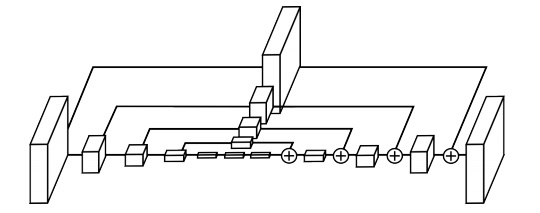

In [216]:
Image('Hourglass_architecture.jpg')

In [217]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
class Residual(nn.Module):
    def __init__(self, in_features, middle_features, use_batchnorm=False):
        super(Residual, self).__init__()
        self.use_batchnorm = use_batchnorm
        # Since we will always have to keep dimensions the same to produce heatmaps,
        # in_features == out_features
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(middle_features)
            self.bn2 = nn.BatchNorm2d(middle_features)
            self.bn3 = nn.BatchNorm2d(in_features)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, middle_features, kernel_size=[1, 1]),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(middle_features, middle_features, kernel_size=[3, 3], padding=[1, 1]),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(middle_features, in_features, kernel_size=[1, 1]),
            nn.ReLU()
        )
        
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        
        out = self.conv2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        
        out = self.conv3(out)
        if self.use_batchnorm:
            out = self.bn3(out)
        
        out += residual
        return out

class Hourglass(nn.Module):
    def __init__(self, in_features=64, middle_features=32, residual_count = 3, use_batchnorm=False):
        self.residual_count = residual_count
        
        super(Hourglass, self).__init__()
        assert self.residual_count >= 1, "Residual count must be >= 1"
        # We are in the center of the network,
        # hence we need just one residual layer
        if self.residual_count == 1:
            self.inner_process = nn.Sequential()
            for i in range(3):
                self.inner_process.add_module(
                    "inner_residual_{}".format(i),
                    Residual(in_features, middle_features, use_batchnorm = use_batchnorm)
                )
            return 
        # We are outside of center, hence we need to recursively define out network
        
        # First downsample and apply residual
        self.down_sample = nn.Sequential(
            nn.MaxPool2d(kernel_size=[2, 2], stride = [2, 2]),
            Residual(in_features, middle_features, use_batchnorm=use_batchnorm)
        )
        # Magic of recursion
        self.inner_hourglass = Hourglass(
            in_features=in_features,
            middle_features=middle_features,
            residual_count = self.residual_count - 1,
            use_batchnorm=use_batchnorm
        )
        # Upsample
        self.up_sample = nn.Sequential(
            # Should test it.
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            Residual(in_features, middle_features, use_batchnorm=use_batchnorm)
        )    
        # Don't forget about transformation
        self.transform = Residual(in_features, middle_features, use_batchnorm=use_batchnorm)
        
    def forward(self, x):
        if self.residual_count == 1:
            return self.inner_process(x)
        else:
            x = self.down_sample(x)
            
            inner_hourglass_out = self.inner_hourglass(x)
            transformation_out = self.transform(x)
            
            x = self.up_sample(transformation_out + inner_hourglass_out)
            return x

## EyePupilNet

This network will be used to extract heatmaps of pupil landmarks using similar approach to the one described in [2]


In [218]:
class EyePupilNet(nn.Module):
    def __init__(self, in_features=64, middle_features=32, residual_count=3, use_batchnorm=True):
        super(EyePupilNet, self).__init__()
        # (N, 3, 80, 120)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=in_features, kernel_size=[3, 3], padding=[1, 1]),
            nn.ReLU()
        )
        # (N, 64, 80, 120)
        self.hourglass1= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass2= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass3= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        # (N, 64, 80, 120)
        self.conv2 = nn.Conv2d(in_channels=in_features, out_channels=8, kernel_size=[1, 1])
    def forward(self, image):
        image = self.conv1(image)
        image = self.hourglass1(image)
        image = self.hourglass2(image)
        image = self.hourglass3(image)
        heatmaps = self.conv2(image)
        return heatmaps

## Approximate heatmaps generation

In [219]:
def generate_gaussian(height, width, x_center, y_center, sigma=10):
    x = torch.arange(height).reshape(height, 1).to(device)
    y = torch.arange(width).reshape(width, 1).T.to(device)
    gauss = torch.exp(-(x-x_center)**2/sigma).matmul(torch.exp(-(y - y_center) ** 2/sigma))
    return gauss

In [220]:
def add(ax, image, heat_map, alpha=0.4, cmap='viridis'):
    height = image.shape[0]
    width = image.shape[1]
 
    # display
    ax.imshow(image)
    ax.imshow(heat_map, alpha=alpha, cmap=cmap)

In [221]:
def create_heatmaps(pupil_landmarks, batch_size=32, height=80, width=120):
    # Since we have 8 landmarks, this number is fixed
    pupil_landmarks_amount = 8
    heatmaps = torch.empty(batch_size, pupil_landmarks_amount, height, width)
    for i in range(batch_size):
        for j in range(pupil_landmarks_amount):
            x = pupil_landmarks[i][2 * j]
            y = pupil_landmarks[i][2 * j + 1]
            heatmaps[i][j] = generate_gaussian(height, width, y, x, sigma=10)
    return heatmaps.float().to(device)

In [233]:
def show_heatmaps(ax, eye, heatmaps):
    _,  H, W = heatmaps.shape
    heatmap = torch.zeros((H, W)).to(device)

    pupil_landmarks_amount = 8
    for idx in range(pupil_landmarks_amount):
        heatmap += heatmaps[idx]
    add(ax, eye, heatmap)

In [258]:
def show_test(model, test_loader, heatmaps_only=False, eye_only=False):
    model.eval()

    iterator = iter(test_loader)
    images, _, pupil_landmarks = next(iterator)
    
    N, M = 5, 5
    heatmaps_only = heatmaps_only
    eyes_only = eye_only
    assert N * M <= 32
    images = images[: N * M].to(device)
    pupil_landmarks = pupil_landmarks[:N * M].to(device)

    with torch.no_grad():
        predictions = model(images)
    
    fig, ax = plt.subplots(ncols=N, nrows=M, figsize=(18, 18))
    for index in range(N * M):
        if heatmaps_only:
            ax[index // N, index % M].imshow(torch.sum(predictions[index], 0))
        elif eyes_only:
            ax[index // N, index % M].imshow(images[index].permute(1, 2, 0))
        elif N != 1 and M != 1:
            show_heatmaps(ax[index // N, index % M], images[index].permute(1, 2, 0), predictions[index])
        elif N == 1 ^ M != 1:
            show_heatmaps(ax[index], images[index], predictions[index])
        elif N == 1 and M == 1:
            show_heatmaps(ax, images[index], predictions[index])

In [246]:
def train(epoch, train_loader, model, optimizer, criterion, train_history):
    model.train()
    
    train_size = len(train_loader)
    meter = AverageMeter()
    for step, (images, _, pupil_landmarks) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        heatmaps = create_heatmaps(pupil_landmarks)
        
        predictions = model(images)
        
        assert predictions.shape == heatmaps.shape
        loss = criterion(predictions, heatmaps)
        loss.backward()   
        
        optimizer.step()
        
        meter.update(loss.item(), 1)
        if step % 50 == 0:
            print("Epoch : {} ({}/{}), loss : {:.2f} ({:.2f})".format(epoch, step, train_size, meter.val, meter.avg))
    train_history.append((epoch, meter.avg))

In [225]:
def test(epoch, test_loader, model, criterion, test_history):
    model.eval()

    meter = AverageMeter()
    test_size = len(test_loader)
    for step, (images, _, pupil_landmarks) in tqdm.tqdm(enumerate(test_loader)):
        images = images.to(device)
        pupil_landmarks = pupil_landmarks.to(device)

        bs = images.size(0)
        with torch.no_grad():
            heatmaps = create_heatmaps(pupil_landmarks, batch_size=bs)
            predictions = model(images)
            loss = criterion(predictions, heatmaps)
        meter.update(loss.item(), 1)
    print("Epoch {}, loss : {:.2f}".format(epoch, meter.avg))
    test_history.append((epoch, meter.avg))

In [226]:
train_history = []
test_history = []

def main():
    model = EyePupilNet(in_features=64, middle_features=32, residual_count=3, use_batchnorm=True)
    model.to(device)
    model.apply(init_weights)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=5e-4,
        betas=[0.9, 0.99],
        eps=1e-8
    )
    criterion = torch.nn.MSELoss(reduction='mean')
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[225],
        gamma=1e-3
    )
    
    epochs = 250
    for epoch in range(1, epochs + 1):
        train(epoch, train_loader, model, optimizer, criterion, train_history)
        
        # Dirty hack to make tqdm work correctly
        print("Evaluating model on test set...")
        scheduler.step()
        
        test(epoch, test_loader, model, criterion, test_history)
        
        if epoch % 15 == 0:
            print("Saving the model...")
            state_dict = model.state_dict()
            torch.save(state_dict, "models/model_state_bn_{}.pth".format(epoch))
            print("Saved successfully")
        
    print("Training ended")

In [ ]:
main()

In [ ]:
draw_histories(train_history, test_history)

In [259]:
model = EyePupilNet()
state_dict = torch.load('EyePupilNet_bn_135.pth')
model.load_state_dict(state_dict)
model.to(device)

EyePupilNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
    (1): ReLU()
  )
  (hourglass1): Hourglass(
    (down_sample): Sequential(
      (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
      (1): Residual(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Sequential(
          (0): Conv2d(64, 32, kernel_size=[1, 1], stride=(1, 1))
          (1): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (1): ReLU()
        )
        (conv3): Sequential(
          (0): Conv2d(32, 64, kernel_size=[1, 1], stride=(1, 1))
          (1): ReLU()
        )
      )
    )
  

Wall time: 3.51 s


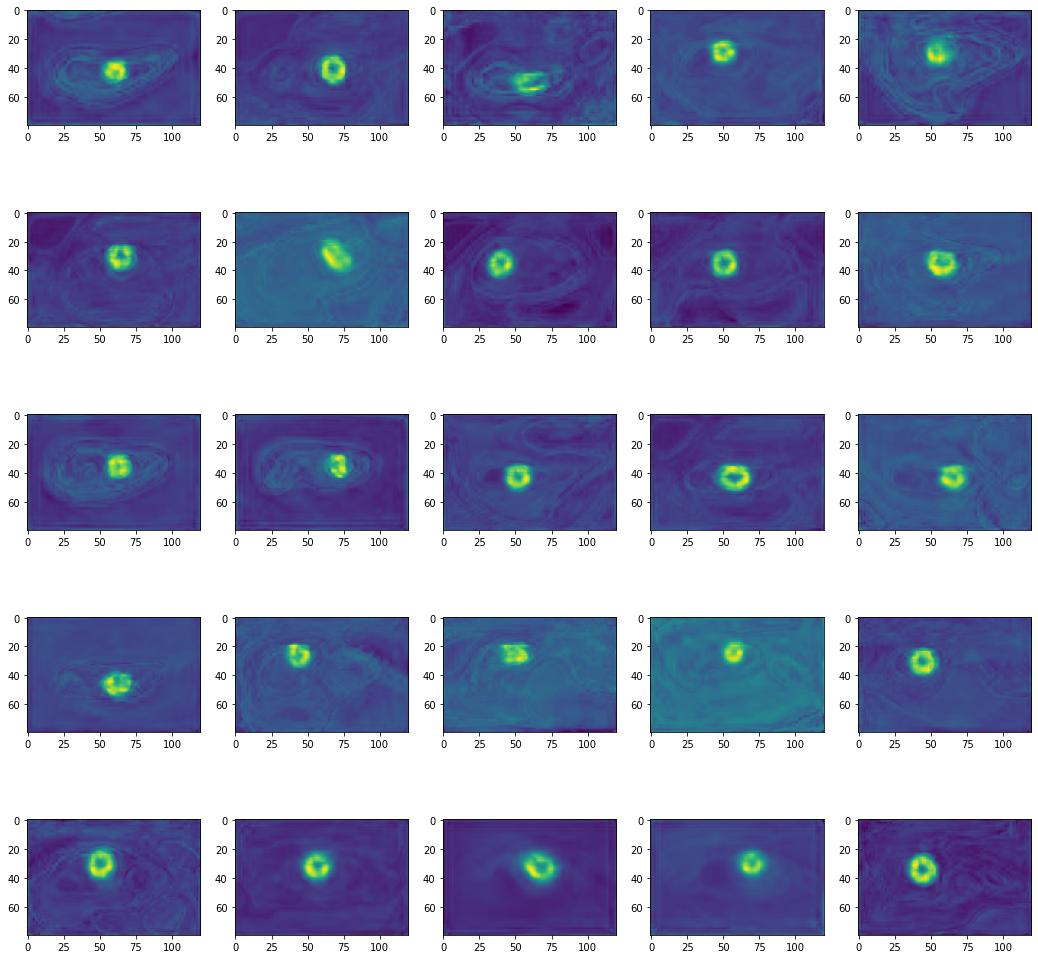

In [260]:
%%time
show_test(model, test_dataloader, heatmaps_only=True)

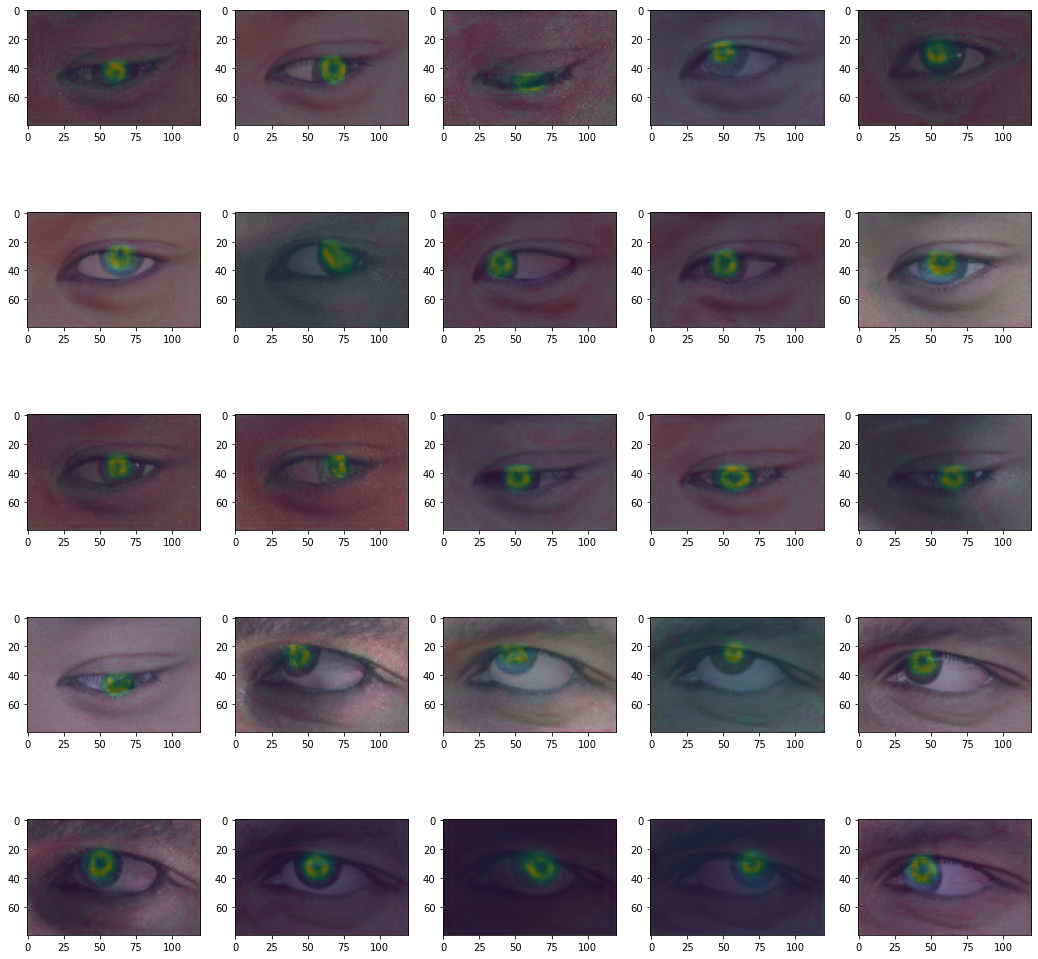

In [265]:
show_test(model, test_dataloader, eye_only=False)

## Loss generation for training EyePupilNet

Let's test `create_heatmaps` function in order to check, if it generates ground-truth heatmaps correctly

In [238]:
iterator = iter(test_dataloader)
images, _, pupil_landmarks = next(iterator)

In [239]:
eye = images[0].permute(1, 2, 0)
eye_pupil_landmarks = pupil_landmarks[0].reshape(1, -1)
print(eye.shape, eye_pupil_landmarks.shape)

torch.Size([80, 120, 3]) torch.Size([1, 16])


In [240]:
hm = create_heatmaps(eye_pupil_landmarks, batch_size = 1)
print(hm.shape)

torch.Size([1, 8, 80, 120])


### Eye image

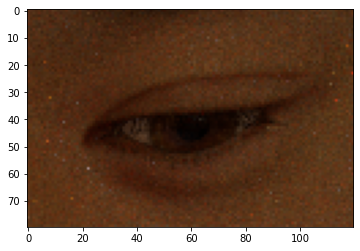

In [241]:
plt.imshow(eye)

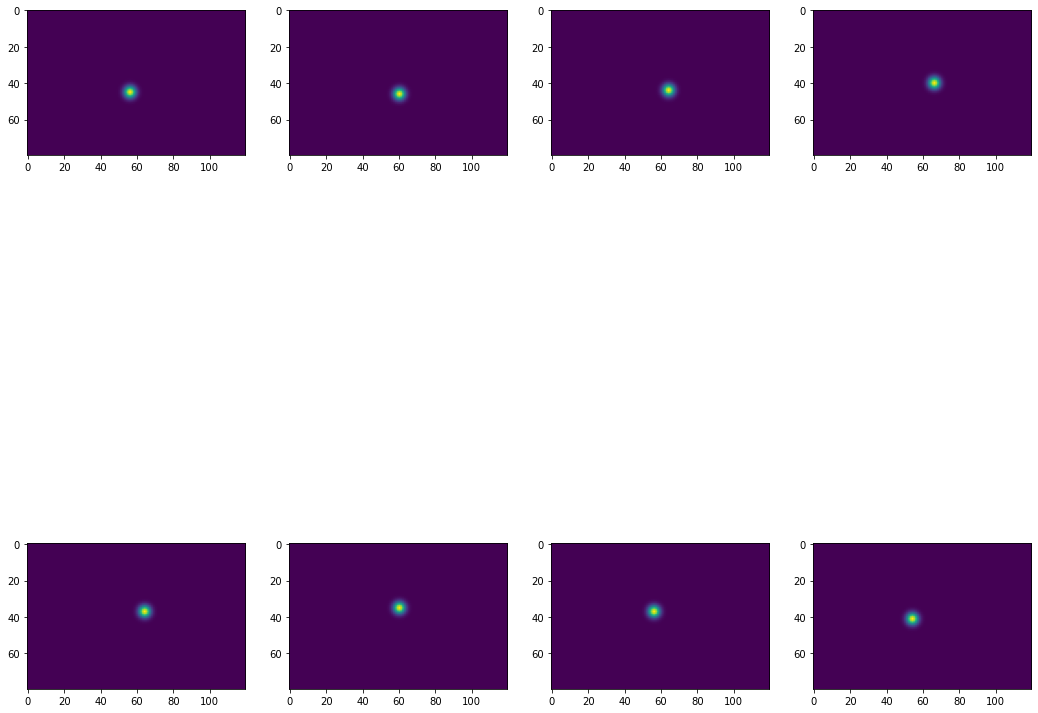

In [245]:
N, M = 2, 4
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 18))
for index in range(N * M):
    ax[index // M, index % M].imshow(hm[0][index])

In [264]:
dummy_tensor = torch.rand(1, 3, 80, 120).to(device)

In [270]:
%%timeit 
model(dummy_tensor)

146 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
